In [ ]:
from tensorflow.keras.datasets import cifar10
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#10 bin örnek
x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:2000], y_test[:2000]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

#Görselleri 1D vektöre çevir
x_train_flat = x_train.reshape(len(x_train),-1)
x_test_flat = x_test.reshape(len(x_test),-1)
print("Train shape",x_train_flat.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
(10000, 32, 32, 3)
(10000, 1)
(2000, 32, 32, 3)
(2000, 1)
Train shape (10000, 3072)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#KNN k=5
knn = KNeighborsClassifier(n_neighbors=5)
#y_train =(10000,1) ravel() --> bazen sklearn hedefi (10000,) istiyebilir ravel bu dönüşümü yapar.
knn.fit(x_train_flat,y_train.ravel())

#Tahmin ve doğruluk
y_pred = knn.predict(x_test_flat)
acc = accuracy_score(y_test,y_pred)
print("KNN Doğruluk Oranı",acc)

KNN Doğruluk Oranı 0.278


In [ ]:
from sklearn.decomposition import PCA

#Gürültü,gereksiz veya tekrarlayan(korrele) pikselleri eler, önemli olan varyansları tutar
pca = PCA(n_components=100)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)
print("Yeni Boyut: ",x_train_pca.shape)

#Şimdi aynı knn parametreleri ile düşük boyut veride deniyoruz
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_pca, y_train.ravel())
y_pred = knn.predict(x_test_pca)
print("PCA+KNN doğruluk:", accuracy_score(y_test, y_pred))

Yeni Boyut:  (10000, 100)
PCA+KNN doğruluk: 0.313


Lineer Classifier


Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=200,verbose=1)

log_reg.fit(x_train_pca,y_train.ravel())
y_pred = log_reg.predict(x_test_pca)
print("PCA+LR doğruluk:", accuracy_score(y_test, y_pred))

PCA+LR doğruluk: 0.3935


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished


Linear SVM

In [ ]:
#Support Vector Machine
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter=5000)
svm.fit(x_train_pca,y_train.ravel())
y_pred = svm.predict(x_test_pca)
print("PCA+SVM doğruluk:", accuracy_score(y_test, y_pred))

PCA+SVM doğruluk: 0.3925


In [ ]:
from sklearn.metrics import hinge_loss

# LinearSVC modelin decision function çıktısı
y_scores = svm.decision_function(x_test_pca)  # shape: (n_samples, n_classes) veya (n_samples,) binary

# y_test etiketlerini {0,1} -> {-1,1} biçimine çevir
y_test_hinge = np.where(y_test.ravel()==0, -1, 1)  # örnek olarak sadece iki sınıf seçmek gerek

# Hinge loss hesapla
loss = hinge_loss(y_test_hinge, y_scores[:,0])  # sadece bir sınıf için örnek
print("Hinge Loss (örnek):", loss)

#sonuç: 1.78 çıktı bu demek oluyor ki yani 0<loss yani modelimde hala hatalı ve margin altında tahmin edilen örnekler fazla


Hinge Loss (örnek): 1.7848514870346799


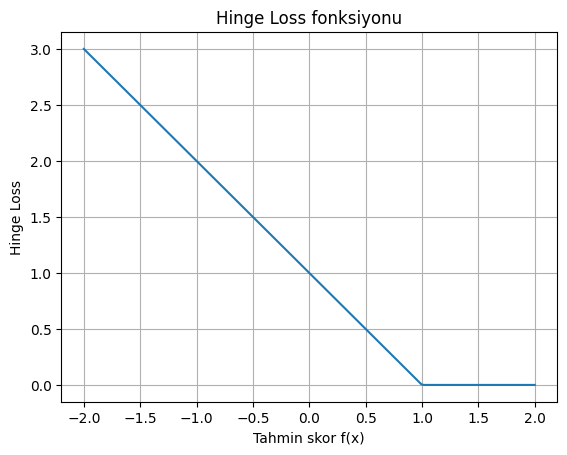

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-2, 2, 200)
y = 1  # gerçek sınıf
hinge = np.maximum(0, 1 - y*x)

plt.plot(x, hinge)
plt.xlabel("Tahmin skor f(x)")
plt.ylabel("Hinge Loss")
plt.title("Hinge Loss fonksiyonu")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_pca)  # veya x_train_flat kullanıyorsan onu ver
x_test_scaled  = scaler.transform(x_test_pca)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

def evaluate_knn(metric_name, k=5):
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric_name, n_jobs=-1)
    t0 = time.time()
    knn.fit(x_train_scaled, y_train.ravel())
    train_time = time.time() - t0

    t1 = time.time()
    y_pred = knn.predict(x_test_scaled)
    pred_time = time.time() - t1

    acc = accuracy_score(y_test, y_pred)
    return acc, train_time, pred_time

for metric in ['euclidean', 'manhattan']:
    acc, tr_t, pr_t = evaluate_knn(metric, k=5)
    print(f"{metric:9s} | acc: {acc:.4f} | fit time: {tr_t:.2f}s | predict time: {pr_t:.2f}s")


euclidean | acc: 0.2375 | fit time: 0.02s | predict time: 0.73s
manhattan | acc: 0.2405 | fit time: 0.01s | predict time: 4.12s


# Softmax

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Softmax classifier
softmax_clf = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    max_iter=1000,
    verbose=1
)

softmax_clf.fit(x_train_pca, y_train.ravel())
y_pred = softmax_clf.predict(x_test_pca)

acc = accuracy_score(y_test, y_pred)
print("PCA + Softmax doğruluk:", acc)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


convergence after 33 epochs took 2 seconds
PCA + Softmax doğruluk: 0.391


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished


In [ ]:
y_proba = softmax_clf.predict_proba(x_test_pca)
print("Test örneği için olasılıklar (ilk 5 örnek):\n", y_proba[:5])
print("Toplam olasılık (ilk örnek):", y_proba[0].sum())  # toplam = 1


Test örneği için olasılıklar (ilk 5 örnek):
 [[0.04120971 0.1014628  0.14333834 0.27240355 0.0101541  0.08414996
  0.21563748 0.00347261 0.12357221 0.00459924]
 [0.04726864 0.12454129 0.00956933 0.00832654 0.00172449 0.00449954
  0.00334717 0.00308319 0.17722421 0.62041561]
 [0.18204357 0.10176718 0.01736492 0.0151545  0.00209901 0.02177719
  0.00305878 0.0059356  0.55530113 0.09549812]
 [0.31401295 0.05883465 0.06287026 0.01674952 0.01706299 0.03201484
  0.00413403 0.08404247 0.38220443 0.02807386]
 [0.01887586 0.03914199 0.16572886 0.05795451 0.42521078 0.07713644
  0.08311773 0.08907123 0.03347272 0.01028988]]
Toplam olasılık (ilk örnek): 1.0000000000000002


In [ ]:
from sklearn.metrics import log_loss

# Test seti için softmax olasılıkları
y_proba = softmax_clf.predict_proba(x_test_pca)

# Cross-entropy loss hesapla
loss = log_loss(y_test, y_proba)
print("Test seti Cross-Entropy Loss:", loss)


Test seti Cross-Entropy Loss: 1.7827296724111603
